In [0]:
#Initializing Spark Session
spark

In [0]:
#Load Data/Preview
artists = spark.read.csv("/Volumes/workspace/default/finalproject/nodes.csv", header=True, inferSchema=True)
collabs = spark.read.csv("/Volumes/workspace/default/finalproject/edges.csv", header=True, inferSchema=True)

display(artists.limit(5))

spotify_id,name,followers,popularity,genres,chart_hits
48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24.0,"['nordic house', 'russelater']",['no (3)']
4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72.0,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', 'vn (1)']"
652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36.0,[],['de (1)']
3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52.0,"['dancehall', 'lovers rock', 'modern reggae', 'reggae fusion']","['at (1)', 'de (1)']"
74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39.0,"['classic swedish pop', 'norrbotten indie', 'swedish pop']",['se (6)']


In [0]:
#Exploratory Analysis
#Schema Review
artists.printSchema()
collabs.printSchema()

#Nodes and Edges Count
print("artists:", artists.count())
print("collabs:", collabs.count())

root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- chart_hits: string (nullable = true)

root
 |-- id_0: string (nullable = true)
 |-- id_1: string (nullable = true)

artists: 156422
collabs: 300386


In [0]:
#Missing Values - Artists
from pyspark.sql.functions import col, isnan, when, count

missing = artists.select([count(when(col(c).isNull(), c)).alias(c) for c in artists.columns]).show()

+----------+----+---------+----------+------+----------+
|spotify_id|name|followers|popularity|genres|chart_hits|
+----------+----+---------+----------+------+----------+
|         0|   0|        4|         0|     0|    136724|
+----------+----+---------+----------+------+----------+



In [0]:
#Filling missing values with a zero
artists = artists.replace("", None)

artists = artists.fillna({"followers": 0,"chart_hits": 0})

In [0]:
#Verifying Missing Values Have Been Corrected
missing = artists.select([count(when(col(c).isNull(), c)).alias(c) for c in artists.columns]).show()

+----------+----+---------+----------+------+----------+
|spotify_id|name|followers|popularity|genres|chart_hits|
+----------+----+---------+----------+------+----------+
|         0|   0|        0|         0|     0|         0|
+----------+----+---------+----------+------+----------+



In [0]:
#Follower Descriptive Stats
artists.select("followers").describe().show()


+-------+-----------------+
|summary|        followers|
+-------+-----------------+
|  count|           156422|
|   mean|86222.05926953541|
| stddev|940091.1869706142|
|    min|           vocal"|
|    max|          99987.0|
+-------+-----------------+



In [0]:
#Locating vocal" error string in followers
bad_rows = artists.filter(col("followers").contains("vocal"))
bad_rows.show(truncate=False)


+----------------------+------------------------------------------+---------+----------+------+----------+
|spotify_id            |name                                      |followers|popularity|genres|chart_hits|
+----------------------+------------------------------------------+---------+----------+------+----------+
|7ti7Mdu4BTfKOYWcI1Q6h8|"Emery ""Detroit Junior"" Williams - piano| vocal"  |0.0       |0     |[]        |
+----------------------+------------------------------------------+---------+----------+------+----------+



In [0]:
#Correcting Follower Error String and Converting Column Attribute
artists = artists.withColumn("followers",
    when(col("followers").contains("vocal"),0).otherwise(col("followers").cast("double")))

In [0]:
#Reviewing Corrected Follower Desecriptive Stats
artists.select("followers").describe().show()

+-------+-----------------+
|summary|        followers|
+-------+-----------------+
|  count|           156422|
|   mean|86221.50805513292|
| stddev|940088.2072405514|
|    min|              0.0|
|    max|     1.02156853E8|
+-------+-----------------+



In [0]:
#Popularity Descriptive Stats
artists.select("popularity").describe().show()

+-------+------------------+
|summary|        popularity|
+-------+------------------+
|  count|            156422|
|   mean|21.157497027272377|
| stddev|18.338289529604022|
|    min|               0.0|
|    max|             100.0|
+-------+------------------+



In [0]:
#Creating Graph via Networkx

#Assembling Edge list
edges = collabs.select("id_0", "id_1")
edges_pd = edges.toPandas()
edge_list = list(zip(edges_pd["id_0"], edges_pd["id_1"]))

#Graph
import networkx as nx
G = nx.Graph()
G.add_edges_from(edge_list)

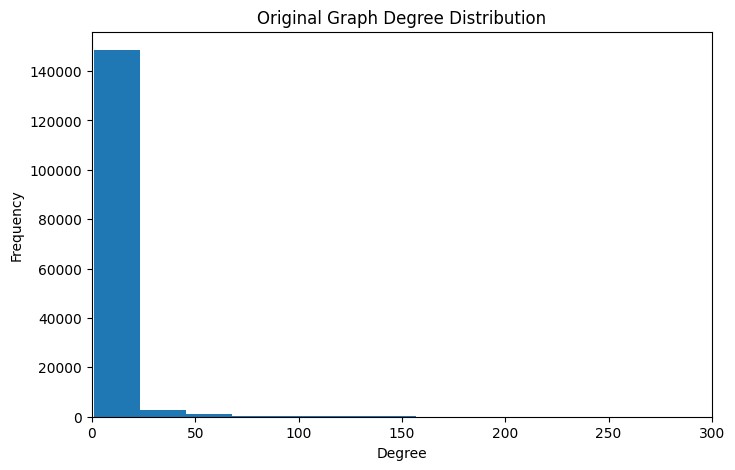

Original graph:
 Nodes: 153327
 Avg degree: 3.9182401012215724
--------------------------------------


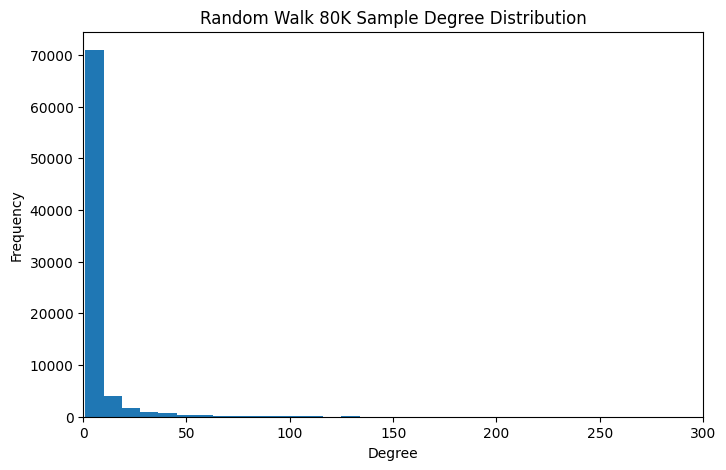

Random walk sample:
 Nodes: 80000
 Avg degree: 5.4182
--------------------------------------


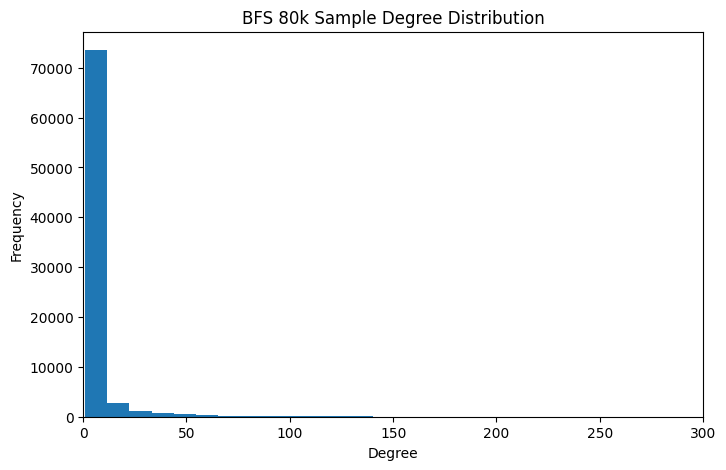

BFS sample:
 Nodes: 80000
 Avg degree: 5.204175
--------------------------------------


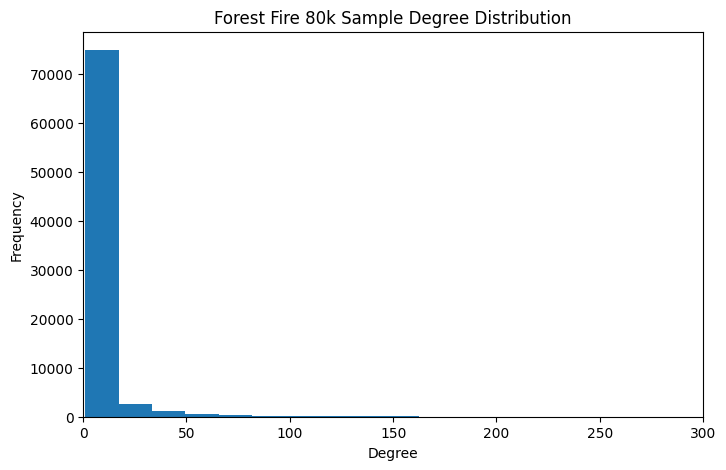

Forest Fire sample:
 Nodes: 80000
 Avg degree: 5.393825


In [0]:
#Graph Visualization Part 1: Degree Disribution
#Reference: https://asmithh.github.io/network-science-data-book/class_03_networkx2.html#plotting-degree-distributions

#Using the Degree Distrbution to choose a Sampling method (80,000 Nodes out of 153,327)
import random
import matplotlib.pyplot as plt
sample_size = 80000
nodes_list = list(G.nodes())

#Original Graph 
degrees_og = [d for _, d in G.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees_og, bins=80)
plt.title("Original Graph Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xlim(0, 300)
plt.show()

print("Original graph:")
print(" Nodes:", G.number_of_nodes())
print(" Avg degree:", sum(degrees_og)/len(degrees_og))
print("--------------------------------------")

#Random Walk 
#(Reference:https://github.com/Ashish7129/Graph_Sampling/blob/master/Graph_Sampling/SRW_RWF_ISRW.py)
def random_walk_sampling(G, sample_size):
    nodes = list(G.nodes())
    start_node = random.choice(nodes)
    sampled = set([start_node])
    current = start_node
    while len(sampled) < sample_size:
        neighbors = list(G.neighbors(current))
        if not neighbors:
            current = random.choice(nodes)
            sampled.add(current)
            continue
        current = random.choice(neighbors)
        sampled.add(current)

    return list(sampled)

nodes_rw = random_walk_sampling(G, sample_size=80000)
G_rw = G.subgraph(nodes_rw).copy()
degrees_rw = [d for _, d in G_rw.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees_rw, bins=80)
plt.title("Random Walk 80K Sample Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xlim(0, 300)
plt.show()

print("Random walk sample:")
print(" Nodes:", G_rw.number_of_nodes())
print(" Avg degree:", sum(degrees_rw)/len(degrees_rw))
print("--------------------------------------")

#Breadth First Search 
#(Reference:https://networkx.org/documentation/stable/_modules/networkx/algorithms/traversal/breadth_first_search.html#bfs_tree  &  https://pelegm-networkx.readthedocs.io/en/latest/_modules/networkx/algorithms/traversal/breadth_first_search.html)
start = random.choice(list(G.nodes()))
nodes_bfs = list(nx.bfs_tree(G, start).nodes())[:80000]
G_bfs = G.subgraph(nodes_bfs).copy()

degrees_bfs = [d for _, d in G_bfs.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees_bfs, bins=80)
plt.title("BFS 80k Sample Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xlim(0, 300)
plt.show()

print("BFS sample:")
print(" Nodes:", G_bfs.number_of_nodes())
print(" Avg degree:", sum(degrees_bfs)/len(degrees_bfs))
print("--------------------------------------")

#Forest Fire
#(Reference:https://github.com/Ashish7129/Graph_Sampling/blob/master/Graph_Sampling/ForestFire.py)
def forest_fire_sample(G, size):
    sampled_nodes = set()

    start_node = random.choice(nodes_list)
    queue = set([start_node])

    while len(sampled_nodes) < size:
        if queue:
            current = queue.pop()
            if current not in sampled_nodes:
                sampled_nodes.add(current)
                neighbors = list(G.neighbors(current))
                if neighbors:
                    burn_count = random.randint(1, len(neighbors))
                    to_burn = neighbors[:burn_count]
                    for nbr in to_burn:
                        if len(sampled_nodes) < size:
                            queue.add(nbr)
                        else:
                            break
        else:
            restart_node = random.choice(list(sampled_nodes))
            queue.add(restart_node)

    return list(sampled_nodes)

nodes_ff = forest_fire_sample(G, sample_size)
G_ff = G.subgraph(nodes_ff).copy()
degrees_ff = [d for _, d in G_ff.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees_ff, bins=80)
plt.title("Forest Fire 80k Sample Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xlim(0, 300)
plt.show()

print("Forest Fire sample:")
print(" Nodes:", G_ff.number_of_nodes())
print(" Avg degree:", sum(degrees_ff)/len(degrees_ff))

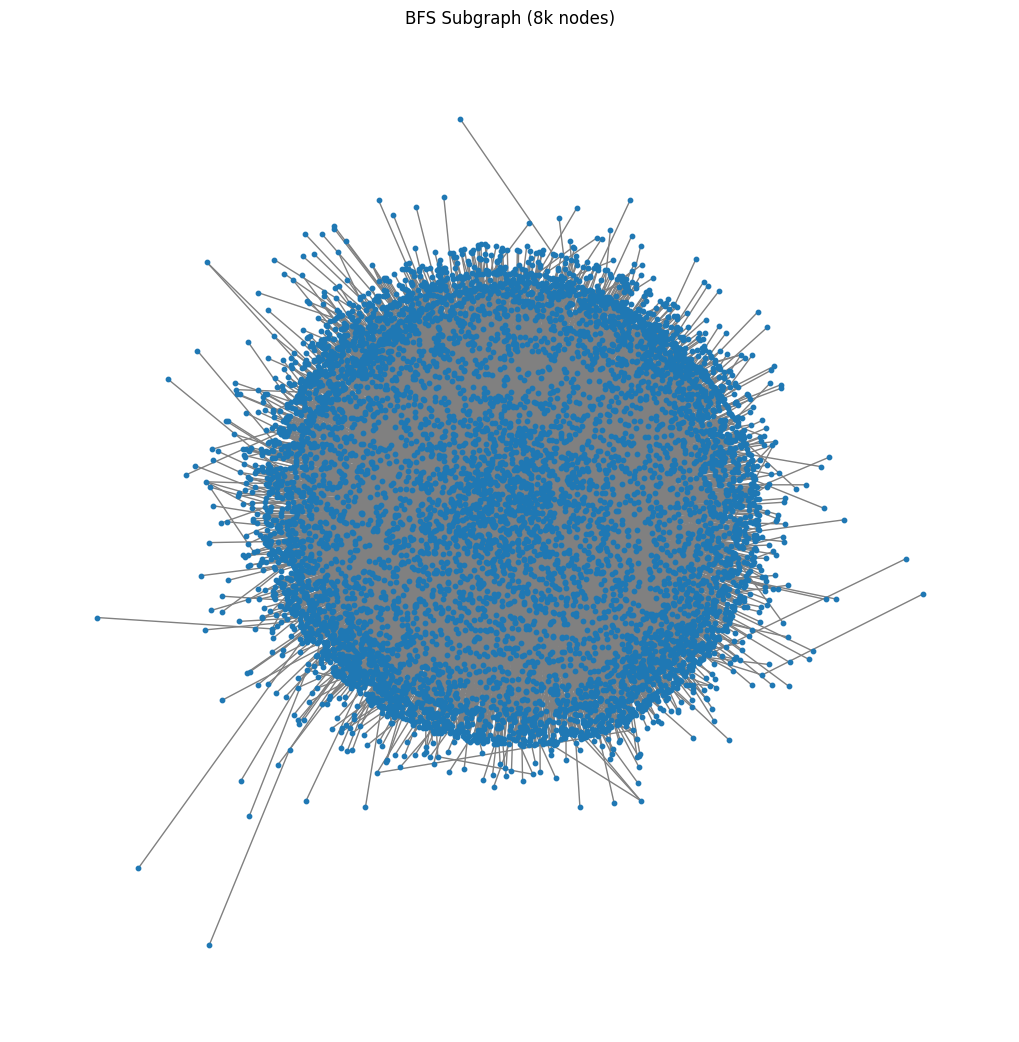

In [0]:
#Graph Visulization: From Graph Subset of 20,000 Nodes Using BFS
#Reference: (https://networkx.org/documentation/stable/reference/algorithms/traversal.html#module-networkx.algorithms.traversal.breadth_first_search &  https://pelegm-networkx.readthedocs.io/en/latest/_modules/networkx/algorithms/traversal/breadth_first_search.html  &  https://prepinsta.com/data-structures-and-algorithms-in-python/breadth-first-search-algorithm/)

#Start Node Selection
degree_dict = dict(G.degree())
start_node = max(degree_dict, key=degree_dict.get)

sample_size = 20000
bfs_nodes = list(nx.bfs_tree(G, start_node).nodes())[:sample_size]
G_bfs = G.subgraph(bfs_nodes).copy()

#Saving Nodes and Edges Subset into DFs
bfs_nodes_df = spark.createDataFrame([(n,) for n in bfs_nodes], ["spotify_id"])
edges_bfs = list(G_bfs.edges())
bfs_edges_df = spark.createDataFrame(edges_bfs, ["id_0", "id_1"])
bfs_nodes_df.write.mode("overwrite").parquet("/Volumes/workspace/default/finalproject/bfs_nodes")
bfs_edges_df.write.mode("overwrite").parquet("/Volumes/workspace/default/finalproject/bfs_edges")

#Visualizing 8000 nodes for cleanliness
sub_nodes = bfs_nodes[:8000]
G_sub = G.subgraph(sub_nodes)

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw(G_sub, pos, node_size=10, edge_color='gray')
plt.title("BFS Subgraph (8k nodes)")
plt.show()



In [0]:
#Creating a dictionary to translate the node attributes
clean_artists = artists.dropDuplicates(["spotify_id"]) #only keeping the first instance of each artists ID for the dictionary,should not interefere with the graph topology
artists_pd = clean_artists.toPandas()

attr_dict = artists_pd.set_index("spotify_id").to_dict("index")
for node in G_bfs.nodes():
    if node in attr_dict:
        for key, value in attr_dict[node].items():
            G_bfs.nodes[node][key] = value

#test print
sample_node = list(G_bfs.nodes())[0]
G_bfs.nodes[sample_node]

{'name': 'DJ Chus',
 'followers': 15484.0,
 'popularity': 40.0,
 'genres': "['afro house', 'funky tech house', 'tribal house', 'vocal house']",
 'chart_hits': '0'}

In [0]:
#Network Properties
components = list(nx.connected_components(G_bfs))
num_components = len(components)
largest_cc = G_bfs.subgraph(max(components, key=len)).copy()

print("Connected components:", num_components)
print("Connected component size:", largest_cc.number_of_nodes())

diameter = nx.diameter(largest_cc)
print("Diameter of BFS subgraph:", diameter)

density = nx.density(G_bfs)
print("Edge density:", density)

degrees = [d for _, d in G_bfs.degree()]
avg_degree = sum(degrees) / len(degrees)
print("Average node degree:", avg_degree)

Connected components: 1
Connected component size: 20000
Diameter of BFS subgraph: 8
Edge density: 0.0002729836491824591
Average node degree: 5.4594


In [0]:
#Centrality Measures
#Degree Centrality 
deg_cent = nx.degree_centrality(G_bfs)

#Estimated Betweenness Centrality (Reduced to 500 nodes for efficient computing)
bet_cent = nx.betweenness_centrality(G_bfs, k=500, seed=42)

#Closeness Centrality
close_cent = nx.closeness_centrality(G_bfs)

#Eigenvector Centrality
eig_cent = nx.eigenvector_centrality(G_bfs)

#PageRank
pr = nx.pagerank(G_bfs)

In [0]:
#Top 5 Most Influential Artists by Centrality Measure
#Degree Centrality
deg_sorted = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)
top5_deg = deg_sorted[:5]

print("\nTop 5 by Degree Centrality:")
for node, value in top5_deg:
    artist = G_bfs.nodes[node].get("name", node)
    print(artist, value)

#Betweenness
bet_sorted = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)
top5_bet = bet_sorted[:5]

print("\nTop 5 by Betweenness Centrality:")
for node, value in top5_bet:
    artist = G_bfs.nodes[node].get("name", node)
    print(artist, value)

#Closeness
close_sorted = sorted(close_cent.items(), key=lambda x: x[1], reverse=True)
top5_close = close_sorted[:5]

print("\nTop 5 by Closeness Centrality:")
for node, value in top5_close:
    artist = G_bfs.nodes[node].get("name", node)
    print(artist, value)


#Eigenvector
eig_sorted = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)
top5_eig = eig_sorted[:5]

print("\nTop 5 by Eigenvector Centrality:")
for node, value in top5_eig:
    artist = G_bfs.nodes[node].get("name", node)
    print(artist, value)


#PageRank
pr_sorted = sorted(pr.items(), key=lambda x: x[1], reverse=True)
top5_pr = pr_sorted[:5]

print("\nTop 5 by PageRank:")
for node, value in top5_pr:
    artist = G_bfs.nodes[node].get("name", node)
    print(artist, value)




Top 5 by Degree Centrality:
Johann Sebastian Bach 0.08905445272263612
Traditional 0.06855342767138356
Jean Sibelius 0.029001450072503623
Steve Aoki 0.02490124506225311
A.R. Rahman 0.023151157557877892

Top 5 by Betweenness Centrality:
Traditional 0.24248528353544088
Johann Sebastian Bach 0.203609040262431
John Williams 0.08379530889380417
Andrea Bocelli 0.06432944355795037
A.R. Rahman 0.04947982900567667

Top 5 by Closeness Centrality:
Traditional 0.3418281885618569
Andrea Bocelli 0.31989698801925875
Johann Sebastian Bach 0.3195340959928421
John Williams 0.317797552836485
Aled Jones 0.30806081424544435

Top 5 by Eigenvector Centrality:
Ty Dolla $ign 0.1511219976551756
Lil Wayne 0.15078102612638225
French Montana 0.15055855200675053
Chris Brown 0.1456408859450186
Gucci Mane 0.13742450533212444

Top 5 by PageRank:
Johann Sebastian Bach 0.036493265789204046
Traditional 0.02668418961665132
Jean Sibelius 0.010923033476945338
John Williams 0.006813181796588694
Andrea Bocelli 0.0048987421633

In [0]:
#Prediction - Linear Regression Model
#Reference: (https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.createDataFrame.html)
#Converting to a SparkDF
centrality_rows = [(node, deg_cent.get(node), bet_cent.get(node), close_cent.get(node), eig_cent.get(node), pr.get(node))
                   for node in G_bfs.nodes()]

centrality_df = spark.createDataFrame(
    centrality_rows, ["spotify_id", "degree_centrality", "betweenness_centrality", "closeness_centrality", "eigenvector_centrality", "pagerank"])

#(preprocessing) Joining artists details with centrality measures
artists_names = artists.select( "spotify_id", col("followers"), col("popularity"))
prepped_df = centrality_df.join(artists_names, on="spotify_id", how="inner")

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Features
assembler = VectorAssembler(
    inputCols=["followers","degree_centrality","betweenness_centrality","closeness_centrality","eigenvector_centrality","pagerank"],
    outputCol="features")

feature_frame = assembler.transform(prepped_df)

# Train/test split
train_df, test_df = feature_frame.randomSplit([0.8, 0.2], seed=42)

# Linear Regression Model
lr = LinearRegression(labelCol="popularity", featuresCol="features")
lr_model = lr.fit(train_df)

# Coefficients
feature_names = ["followers","degree_centrality","betweenness_centrality","closeness_centrality","eigenvector_centrality","pagerank"]
print("Features:", feature_names)
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

# Evaluation
test_results = lr_model.evaluate(test_df)
print("RMSE:", test_results.rootMeanSquaredError)
print("R²:", test_results.r2)


Features: ['followers', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
Coefficients: [1.3463993219983585e-06,17784.702510295778,-1510.747308937671,41.45773750774834,-141.6161589773447,-33353.12966993679]
Intercept: 14.34285588011909
RMSE: 18.989818328528052
R²: 0.24748483658436327


In [0]:
#K means Clustering
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

# Standardizing features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(feature_frame)
scaled_df = scaler_model.transform(feature_frame)

#KMeans
kmeans = KMeans(featuresCol="scaled_features", k=6, seed=42)
kmeans_model = kmeans.fit(scaled_df)
clustered_df = kmeans_model.transform(scaled_df)

clusters_with_names = clustered_df.join(artists.select("spotify_id", "name"),on="spotify_id",how="left")
clusters_with_names.select("name", "prediction").show(20, truncate=False)

+-------------------+----------+
|name               |prediction|
+-------------------+----------+
|Kontra K           |0         |
|Christopher Martin |0         |
|Danny Elfman       |0         |
|Vybz Kartel        |0         |
|Apocalyptica       |0         |
|Dua Lipa           |5         |
|Stefanie Sun       |3         |
|Nobuo Uematsu      |0         |
|Alex Ubago         |0         |
|Jülevenner         |3         |
|Rasster            |3         |
|Kobi Peretz        |3         |
|Lauana Prado       |3         |
|Herbert Grönemeyer |0         |
|Joe Stone          |0         |
|Protoje            |0         |
|Lars-Erik Larsson  |0         |
|Andre Hazes        |3         |
|Kygo               |4         |
|Ocean Park Standoff|0         |
+-------------------+----------+
only showing top 20 rows


k=2, WSSSE=81197.42324687523
k=3, WSSSE=57306.490267511406
k=4, WSSSE=56664.051618819656
k=5, WSSSE=43046.388605539745
k=6, WSSSE=29581.702229703104
k=7, WSSSE=24376.628536631986
k=8, WSSSE=23780.042032855094
k=9, WSSSE=19020.31152096968


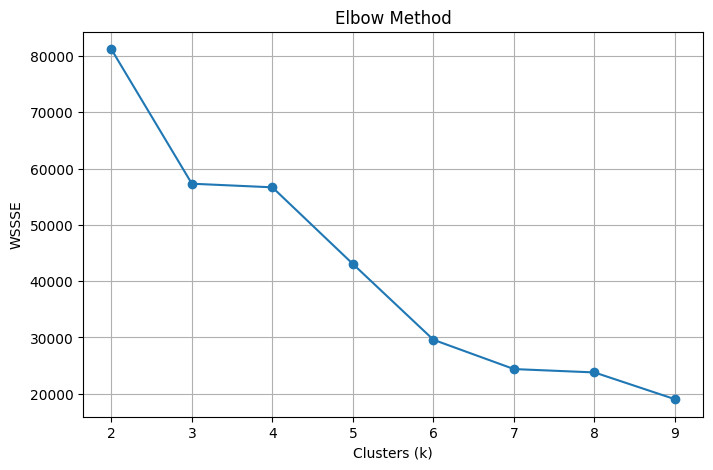

In [0]:
#Finding the optimal K Clusters in Previous Code --- Elbow Method
#Reference: https://www.machinelearningplus.com/pyspark/pyspark-mllib-k-means-clustering/
values = []

for k in range(2, 10):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(scaled_df)
    wssse = model.summary.trainingCost
    values.append((k, wssse))
    print(f"k={k}, WSSSE={wssse}")

k_values = [k for k, _ in values]
wssse_values = [w for _, w in values]

plt.figure(figsize=(8,5))
plt.plot(k_values, wssse_values, marker='o', linestyle='-')
plt.xticks(k_values)
plt.xlabel("Clusters (k)")
plt.ylabel("WSSSE")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

In [0]:
#Cluster Analysis
from pyspark.sql.functions import avg, count, min, max

cluster_summary = clustered_df.groupBy("prediction").agg(count("*").alias("num_artists"),
    avg("followers"),avg("degree_centrality"),avg("betweenness_centrality"),avg("closeness_centrality"),
    avg("eigenvector_centrality"),avg("pagerank"),min("popularity"),max("popularity"),avg("popularity"))

print("Characteristics by Cluster")
display(cluster_summary.orderBy("prediction"))

Characteristics by Cluster


prediction,num_artists,avg(followers),avg(degree_centrality),avg(betweenness_centrality),avg(closeness_centrality),avg(eigenvector_centrality),avg(pagerank),min(popularity),max(popularity),avg(popularity)
0,8431,378203.84580714034,3.713149718688642E-4,2.256769127619577E-4,0.2397689464681827,0.0017093582782959917,5.9823216385297775E-5,0.0,88.0,30.83738583797889
1,2,1875289.0,0.07880394019700984,0.22304716189893595,0.3306811422773495,0.0015043852664230384,0.031588727702927685,59.0,75.0,67.0
2,30,2859885.5,0.011818924279547309,0.02728553889047507,0.2748416140802203,0.0083376802110264,0.003048575808321414,22.0,84.0,61.166666666666664
3,11347,73201.97347316472,9.350515996761323E-5,1.1751719280429758E-5,0.2026659089720053,1.2525459647337004E-4,2.4682485887852754E-5,0.0,85.0,22.406803560412445
4,160,6597239.74375,0.003966760838041902,0.001657735803810026,0.25952591188086915,0.06272840254795381,3.1484507101112456E-4,56.0,91.0,75.4125
5,46,3.761765706521739E7,0.0029121021268454722,0.0018814809430400814,0.256728813230689,0.026145118317948274,2.701277195711492E-4,73.0,100.0,85.26086956521739


In [0]:
#Printing Cluster 1 Artists
display(clusters_with_names.filter(col("prediction") == 1).select("name"))


name
Johann Sebastian Bach
Traditional
